# Walmart Trip Type Classification
### Capstone Project - 1
### By: * Rajesh Dharmarajan *
******************
_This is the first capstone project for my Springboard Career Track. This is a classification problem with Data from Walmart to predict the Trip Type. This is orginally from a Kaggle competition_

** Overview **


Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types. 

Whether they're on a last minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.

Currently, Walmart's trip types are created from a combination of existing customer insights ("art") and purchase history data ("science"). 

The challenge here is to classify customer trips using only a transactional dataset of the items they've purchased.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification


In [1]:
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
#matplotlib inline
#%matplotlib notebook
import seaborn as sns
pd.set_option('display.max_columns', None)

** Read the file **

In [2]:
df_walmart_raw = pd.read_csv('wm_train.csv')

**Data fields**

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
* VisitNumber - an id corresponding to a single trip by a single customer
* Weekday - the weekday of the trip
* Upc - the UPC number of the product purchased
* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
* DepartmentDescription - a high-level description of the item's department
* FinelineNumber - a more refined category for each of the products, created by Walmart

In [4]:
df_walmart_raw.head(5)

TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

In [5]:
df_walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB




Lets look at the data
****

In [6]:
unique_trips = len(df_walmart_raw.VisitNumber.unique())# number of unique trips - 95,674

In [7]:
unique_UPC = len(df_walmart_raw.Upc.unique())# number of unique UPC - 97,715

In [8]:
unique_FilelineNumber = len(df_walmart_raw.FinelineNumber.unique()) # number of unique FinelineNumber - 5,196

In [9]:
unique_TripTypes = len(df_walmart_raw.TripType.unique())#38 different types of Trips

In [10]:
unique_departments = len(df_walmart_raw.DepartmentDescription.unique())#69 different types of departments

In [11]:
# Check if there are any rows where UPC is present, but Department Description is not present
df_walmart_raw[((df_walmart_raw.DepartmentDescription.isnull()) & (df_walmart_raw.Upc.notnull()))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [12]:
# Check if there are any rows where UPC is present, but Fineline Number is not present
df_walmart_raw[((df_walmart_raw.FinelineNumber.isnull()) & (df_walmart_raw.Upc.notnull()))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [13]:
#let us look at rows that have null UPC
df_null_upc=df_walmart_raw[(df_walmart_raw.Upc.isnull())]

In [14]:
len(df_null_upc)#a total of 4,129 rows have null UPC

4129

In [15]:
#let us look at a few rows
df_null_upc.head(10)

TripType  VisitNumber Weekday  Upc  ScanCount DepartmentDescription  \
25          26            8  Friday  NaN          1                   NaN   
548         27          259  Friday  NaN          3                   NaN   
549         27          259  Friday  NaN          1                   NaN   
959        999          409  Friday  NaN         -1                   NaN   
1116        39          479  Friday  NaN          1                   NaN   
1134       999          484  Friday  NaN         -2                   NaN   
1135       999          484  Friday  NaN         -2                   NaN   
1155        44          496  Friday  NaN          1           PHARMACY RX   
1216         5          521  Friday  NaN          1           PHARMACY RX   
1373         5          585  Friday  NaN          1           PHARMACY RX   

      FinelineNumber  
25               NaN  
548              NaN  
549              NaN  
959              NaN  
1116             NaN  
1134             NaN  
1135             NaN  
1155             NaN  
1216             NaN  
1373             NaN

From the above, we see that the `FinelineNumber` is also $null$ when the `UPC` is null. There are some rows where `DepartmentDescription` is present and all of the null UPC rows have a valid `ScanCount` . Let us check if there are any other departments other than Pharmacy in these null UPC data.

In [16]:
df_null_upc[((df_null_upc.DepartmentDescription.notnull()) & 
             (df_null_upc.DepartmentDescription != 'PHARMACY RX'))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

***
Check if these data with null UPC numbers have a valid Fineline Number

In [17]:
df_null_upc[(df_null_upc.FinelineNumber.notnull()) ]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [18]:
#let us look at the distribution of the TripTypes when UPC is null
df_null_upc.TripType.value_counts()

5      2583
999     352
40      193
39      135
25      116
9        82
8        78
37       68
44       63
42       50
36       49
24       48
38       40
43       38
32       31
7        31
15       21
41       18
33       16
30       15
27       13
34       12
22       11
35        9
21        7
20        7
18        6
28        6
3         5
4         5
29        5
31        4
26        4
12        4
6         3
19        1
Name: TripType, dtype: int64

Remove these rows from the data since, without knowning what the customer bought or returned, the trip cannot be classified. So, discard these rows

In [7]:
#df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())&(df_walmart_raw.DepartmentDescription.notnull())]
df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())]

In [20]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['VisitNumber']==8784]

TripType  VisitNumber   Weekday           Upc  ScanCount  \
28348        40         8784  Saturday  8.402160e+10          1   
28349        40         8784  Saturday  3.890000e+09          1   
28350        40         8784  Saturday  2.700038e+09          1   
28351        40         8784  Saturday  4.133344e+09          1   
28352        40         8784  Saturday  8.200073e+09          1   
28353        40         8784  Saturday  7.342000e+09          1   
28354        40         8784  Saturday  4.510006e+09          1   
28355        40         8784  Saturday  1.312000e+09          1   
28356        40         8784  Saturday  2.310001e+09          2   
28357        40         8784  Saturday  7.874209e+09          1   
28358        40         8784  Saturday  4.790051e+09          1   
28359        40         8784  Saturday  3.810033e+09          1   
28360        40         8784  Saturday  2.310002e+09          5   
28361        40         8784  Saturday  4.222281e+09          2   
28362        40         8784  Saturday  7.874209e+09          1   
28363        40         8784  Saturday  7.432300e+09          1   
28364        40         8784  Saturday  6.233894e+09          1   

          DepartmentDescription  FinelineNumber  
28348                HOME DECOR          1629.0  
28349         GROCERY DRY GOODS          2757.0  
28350         GROCERY DRY GOODS          2301.0  
28351       IMPULSE MERCHANDISE           902.0  
28352          LIQUOR,WINE,BEER          1111.0  
28353                     DAIRY          1353.0  
28354               DSD GROCERY          2536.0  
28355              FROZEN FOODS          1801.0  
28356         PETS AND SUPPLIES           610.0  
28357           PRE PACKED DELI          7199.0  
28358         GROCERY DRY GOODS          2452.0  
28359         PETS AND SUPPLIES           410.0  
28360         PETS AND SUPPLIES           610.0  
28361           PRE PACKED DELI          7506.0  
28362         GROCERY DRY GOODS          2302.0  
28363               DSD GROCERY          2704.0  
28364  HOUSEHOLD CHEMICALS/SUPP          8945.0

In [21]:
no_of_obs = len(df_walmart_1st_cleanse) # 645,693 observations after dropping the ones with null UPCs

In [22]:
unique_nonnull_trips = len(df_walmart_1st_cleanse.VisitNumber.unique())# number of unique trips - 95,674

In [23]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 642925 non-null int64
VisitNumber              642925 non-null int64
Weekday                  642925 non-null object
Upc                      642925 non-null float64
ScanCount                642925 non-null int64
DepartmentDescription    642925 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


***
** Analyze UPCs that occur just once **

In [24]:
#get all the UPCs that show up just once 
count_series = df_walmart_1st_cleanse.Upc.value_counts()
count_series = count_series[count_series.values<2]

In [25]:
#get the UPCs into a list
upc_once_occurs_list = count_series.axes[0]

In [26]:
#get the list of VisitNumbers that have the UPCs that occcur just once
upc_once_visits = df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(upc_once_occurs_list)].VisitNumber.unique()

In [27]:
len(upc_once_occurs_list)
# there are 37,080 UPCs that occur only once, total unique UPCs - 97,715

37080

In [28]:
len(upc_once_visits)
#22,415 visits contain UPCs that occur only once, total number of visits in this data 95,674

22415

***

### Check the distribution of UPC and Department

In [3]:
upc_counts = pd.DataFrame(df_walmart_raw.groupby('Upc').size().sort_values(ascending=False))#.head(10000).sum() #.plot()
#100-65845
#1000-170277
#10000-390185

In [4]:
upc_counts=upc_counts.reset_index().reset_index()
upc_counts.columns=['ixnum','Upc','Counts']

In [5]:
upc_counts['str_upc']=upc_counts['Upc'].apply(str)
upc_counts['str_upc']=upc_counts.str_upc.map(lambda x : x[:-2])
upc_counts['cum_sum']=upc_counts.Counts.cumsum()

In [32]:
upc_counts.head(5)

ixnum           Upc  Counts      str_upc  cum_sum
0      0  4.011000e+03    7657         4011     7657
1      1  6.053886e+10    2501  60538862097    10158
2      2  7.874235e+09    2067   7874235186    12225
3      3  7.874235e+09    1883   7874235187    14108
4      4  4.046000e+03    1652         4046    15760

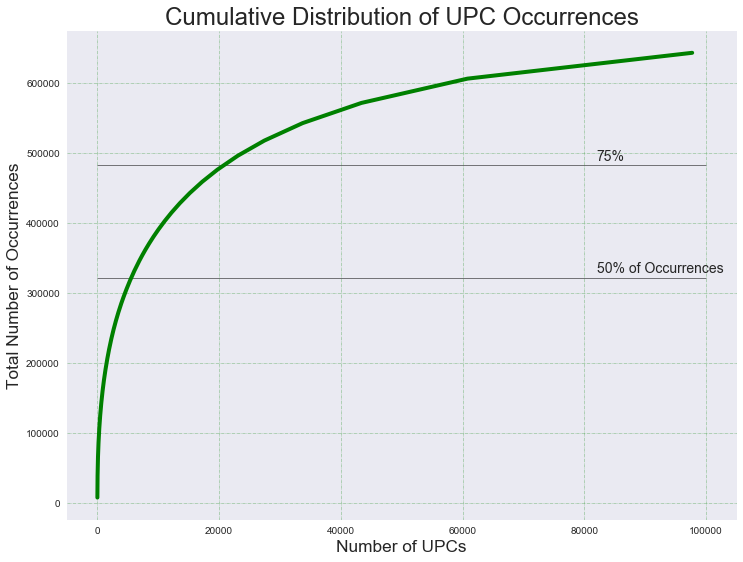

In [33]:
f,ax=plt.subplots(figsize=(12,9))
plt.plot(upc_counts.Counts.cumsum(),linewidth=4,color='g')#
plt.grid(True, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
plt.grid(True, 'major','x', ls='-.', lw=.5, c='g', alpha=.5)
plt.ylabel('Total Number of Occurrences',fontsize='x-large')
plt.xlabel('Number of UPCs',fontsize='x-large')
plt.hlines(upc_counts.Counts.sum()/2,0,100000,linewidth=0.5)
plt.text(82000,330000,'50% of Occurrences',fontsize=14)
plt.hlines(upc_counts.Counts.sum()*0.75,0,100000,linewidth=0.5)
plt.text(82000,490000,'75%',fontsize=14)
plt.title('Cumulative Distribution of UPC Occurrences',fontsize=24)
plt.show()

In [34]:
upc_occ_sr=upc_counts[['Counts']].groupby((upc_counts.ixnum+10000)//10000*10000).sum()

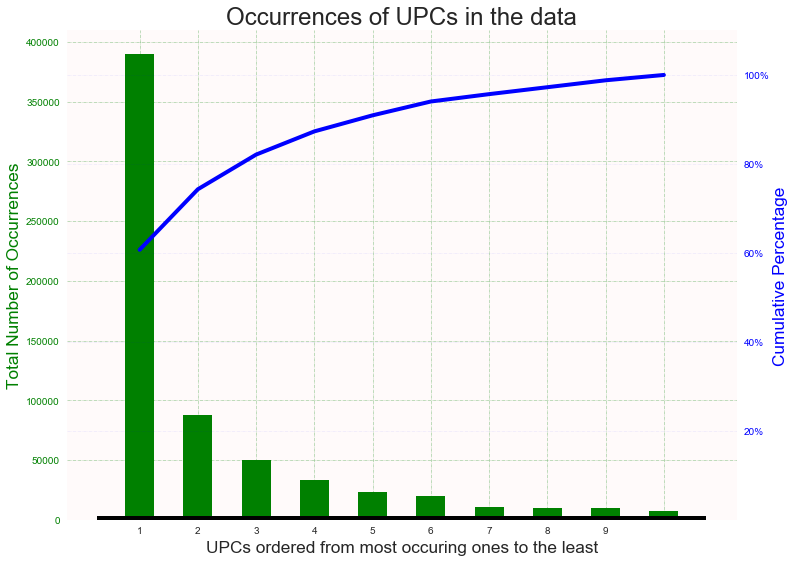

In [35]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ind=np.arange(10)
ax.set_facecolor(color='snow')
ax.bar(ind, upc_occ_sr.values,width,color='g')
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.set_xlabel('UPCs ordered from most occuring ones to the least',fontsize='x-large')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax.grid(True, 'major','x', ls='-.', lw=.5, c='g', alpha=.5)
ax.tick_params('y', colors='g')
plt.xticks(ind,np.arange(1,10,1))
plt.title('Occurrences of UPCs in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,(upc_occ_sr.cumsum()/upc_occ_sr.sum()),color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(True, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,1.1)
plt.hlines(0,ax2.get_xlim()[0],ax2.get_xlim()[1],color='k',linewidth=8)
plt.show()

In [172]:
dept_counts = pd.DataFrame(df_walmart_raw.groupby('DepartmentDescription').size().sort_values(ascending=False))
dept_counts=dept_counts.reset_index().reset_index()
dept_counts.columns=['ixnum','Dept','Count']

In [173]:
dept_counts.head(10)

ixnum                      Dept  Count
0      0         GROCERY DRY GOODS  70402
1      1               DSD GROCERY  68332
2      2                   PRODUCE  51115
3      3                     DAIRY  43820
4      4             PERSONAL CARE  41969
5      5       IMPULSE MERCHANDISE  28712
6      6  HOUSEHOLD CHEMICALS/SUPP  24880
7      7              PHARMACY OTC  23306
8      8              FROZEN FOODS  21101
9      9     HOUSEHOLD PAPER GOODS  16274

In [204]:
sortedDept = pd.DataFrame(pd.DataFrame.copy(df_walmart_raw.DepartmentDescription))
sort_dept_desc = sortedDept.groupby(['DepartmentDescription']).size().sort_values(ascending=False)

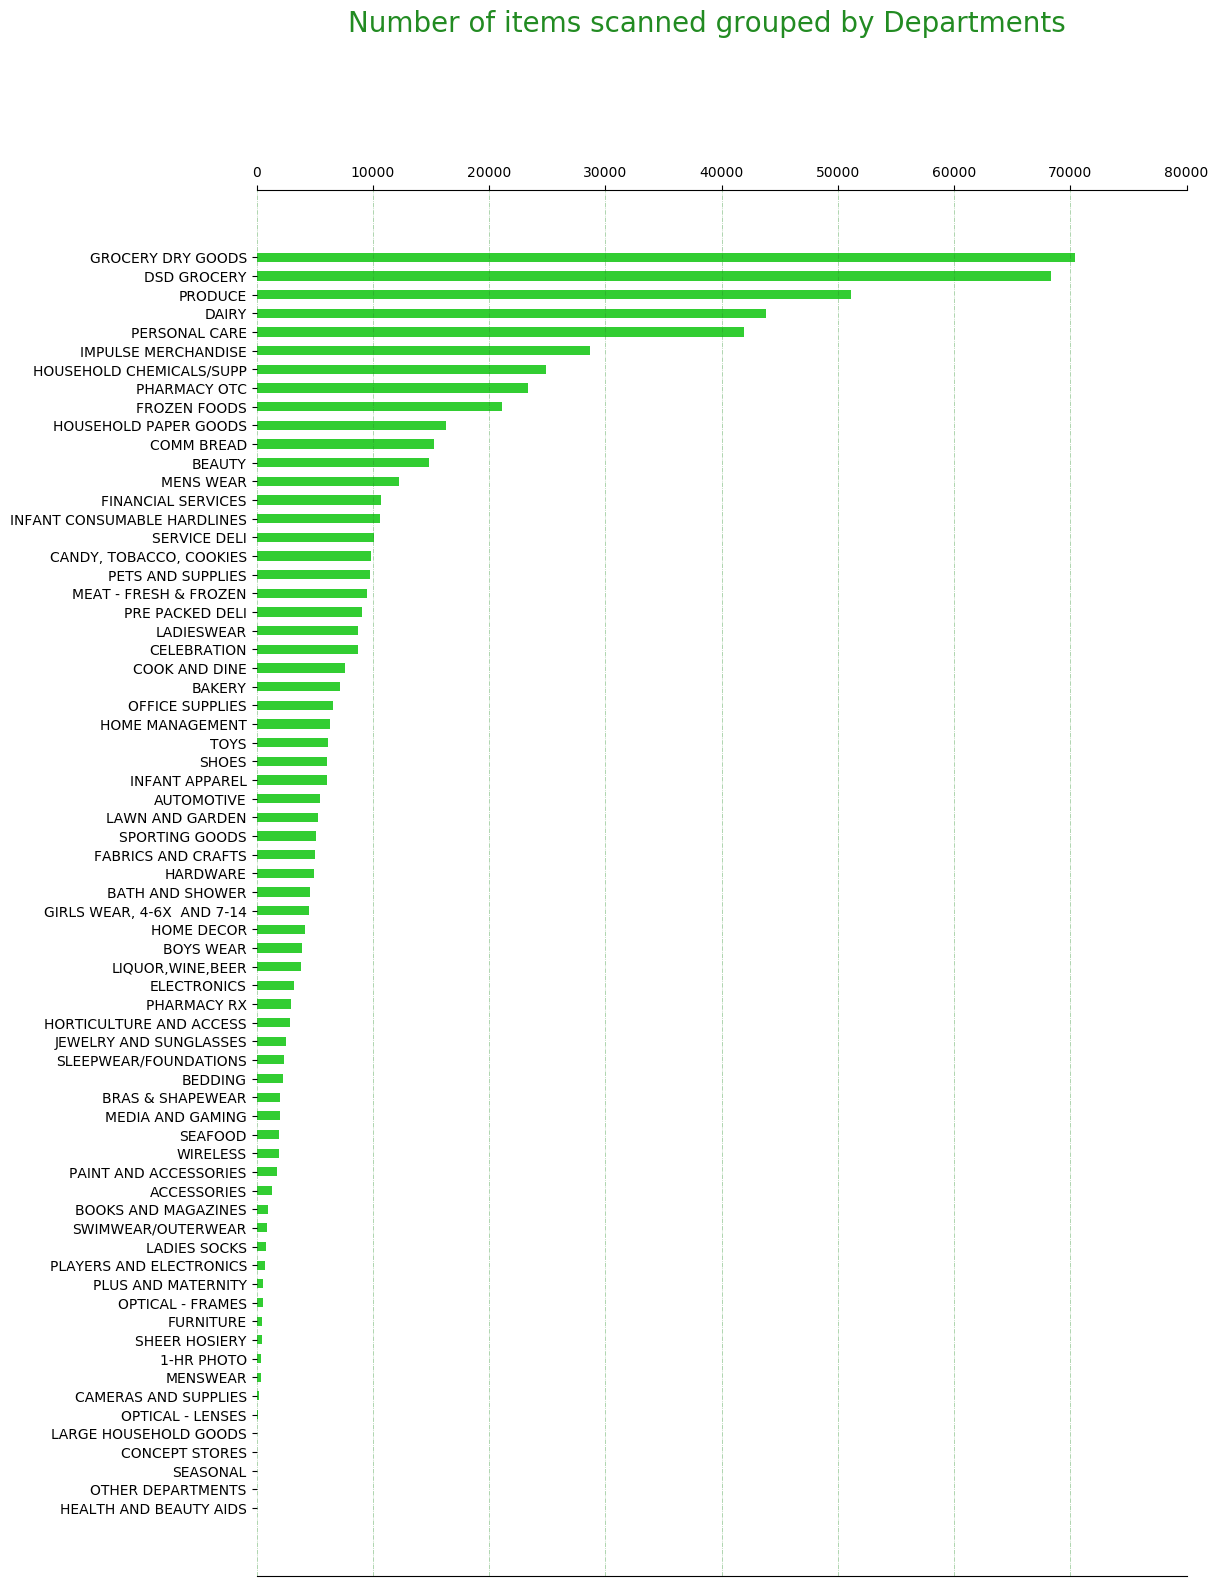

In [229]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,18))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.grid(True, 'major', 'x', ls='-.', lw=.5, c='forestgreen', alpha=.5)

val_labels = sort_dept_desc.index
y_pos = np.arange(len(sort_dept_desc))
vals = sort_dept_desc.values
error = np.random.rand(len(sort_dept_desc))
ax.barh(y_pos, vals, xerr=error, align='center',height=0.5,color='limegreen')
ax.set_yticks(y_pos)
ax.set_yticklabels(val_labels)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim(0,80000)
plt.suptitle('Number of items scanned grouped by Departments', fontsize=20,color='forestgreen')
#plt.savefig('items_by_dept.png')
plt.show()

In [38]:
dept_occ_sr=dept_counts[['Count']].groupby((dept_counts.ixnum+10)//10*10).sum()

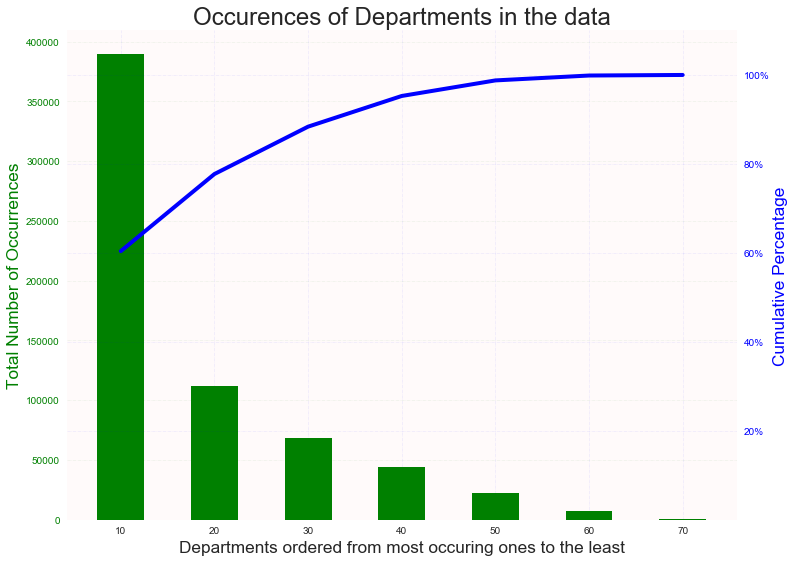

In [39]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ind=np.arange(7)
ax.set_facecolor(color='snow')
ax.bar(ind, dept_occ_sr.values,width,color='green')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='green', alpha=.1)
ax.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.tick_params('y', colors='g')
plt.xlabel('Departments ordered from most occuring ones to the least',fontsize='x-large')
plt.xticks(ind,np.arange(10,80,10))
plt.title('Occurences of Departments in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,(dept_occ_sr.cumsum()/dept_occ_sr.sum()),color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,1.1)
#plt.hlines(0,ax2.get_xlim()[0],ax2.get_xlim()[1],color='k',linewidth=4)

plt.show()

In [40]:
flno_counts=pd.DataFrame(df_walmart_raw.groupby('FinelineNumber').size().sort_values(ascending=False))
flno_counts=flno_counts.reset_index().reset_index()
flno_counts.columns = ['ixnum','FinelineNumber','TotOcc']

In [41]:
flno_counts['GrpBy500']=((flno_counts.ixnum+500)//500)*500
flno_sum_sr=flno_counts[['GrpBy500','TotOcc']].groupby('GrpBy500').sum()
flno_sum_sr=flno_sum_sr.reset_index()
flno_sum_sr['CumSum']=(flno_sum_sr.TotOcc.cumsum()/flno_sum_sr.TotOcc.sum())*100

In [42]:
flno_sum_sr.head()

GrpBy500  TotOcc     CumSum
0       500  375919  58.470117
1      1000  109800  75.548314
2      1500   61269  85.078042
3      2000   36976  90.829257
4      2500   23166  94.432477

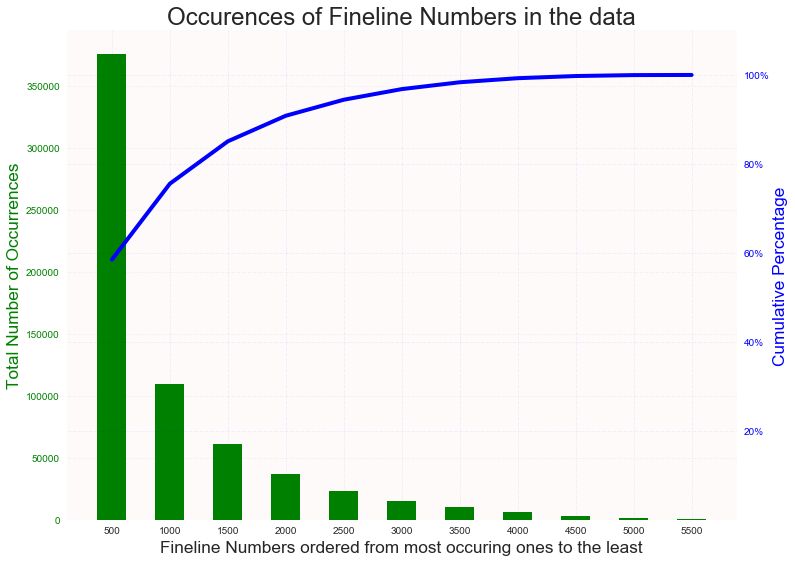

In [43]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ax.set_facecolor(color='snow')
ind=np.arange(len(flno_sum_sr))
ax.bar(ind, flno_sum_sr.TotOcc,width,color='green')
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.tick_params('y', colors='g')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='green', alpha=.1)
ax.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
plt.xlabel('Fineline Numbers ordered from most occuring ones to the least',fontsize='x-large')
plt.xticks(ind,np.arange(500,6000,500))
plt.title('Occurences of Fineline Numbers in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,flno_sum_sr.CumSum,color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,110)

plt.show()

## Check if the  trip types are related to day of the Week

In [208]:
trip_types=df_walmart_1st_cleanse.TripType.unique()#.sort(axis=0) #.sort_values()

In [209]:
trip_types.sort(axis=0)

In [210]:
days_of_week=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [211]:
df_days_triptype=pd.DataFrame(df_walmart_1st_cleanse[['Weekday','TripType']].groupby(['TripType','Weekday']).size())

In [212]:
df_days_triptype=df_days_triptype.unstack('Weekday',fill_value=0)

In [213]:
df_days_triptype.head()

0                                                  
Weekday  Friday Monday Saturday Sunday Thursday Tuesday Wednesday
TripType                                                         
3          1408    830     1167    901      760     860       896
4           150    111      164    151      106      96       118
5          1765   1464     1966   1558     1462    1468      1570
6           655    336      855    442      378     351       385
7          3233   3292     3571   4009     2859    2967      3237

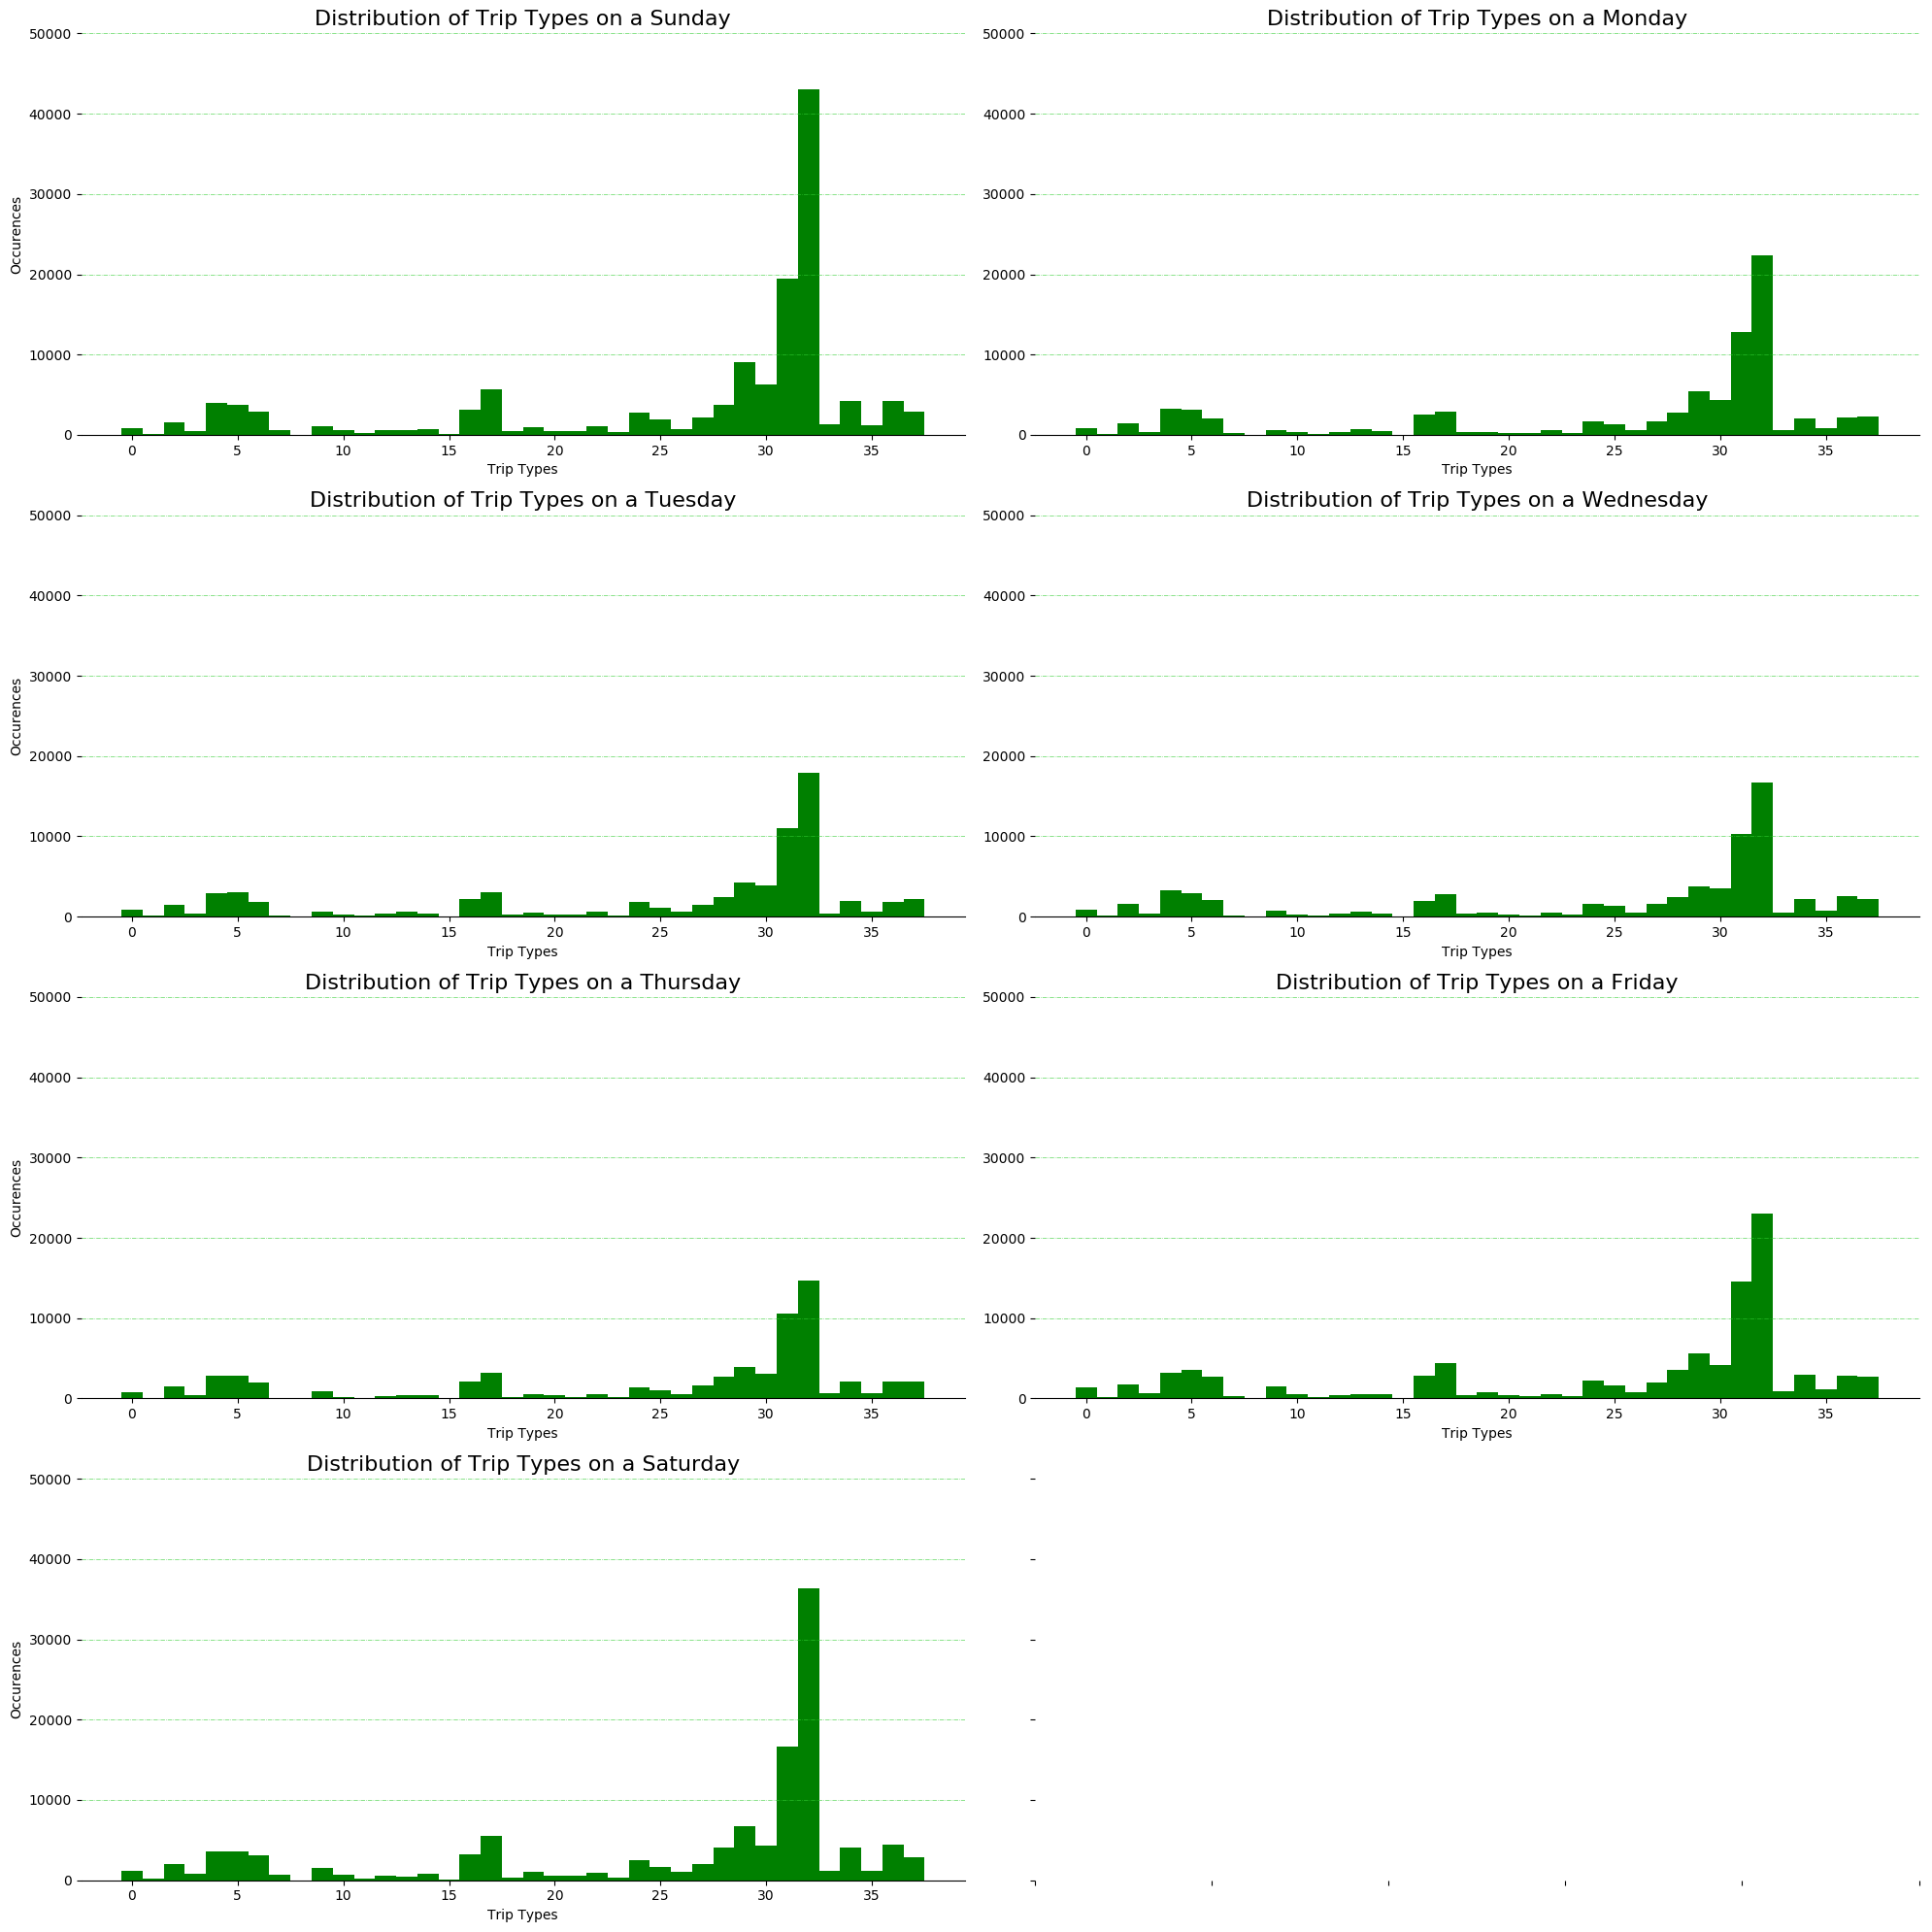

In [228]:
plt.rcdefaults()
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,20))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
ind=np.arange(len(trip_types))
width=1.0
btm=0
tp=50000
clr='green'

ax0.bar(ind, df_days_triptype[[0][0]]['Sunday'].values,width,color=clr)
ax0.set_title('Distribution of Trip Types on a Sunday',fontsize=16)
ax0.set_ylim(bottom=btm,top=tp,auto=False)
ax0.set_xlabel('Trip Types')
ax0.set_ylabel('Occurences')
ax0.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax0.spines['left'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)


ax1.bar(ind, df_days_triptype[[0][0]]['Monday'].values,width,color=clr)
ax1.set_title('Distribution of Trip Types on a Monday',fontsize=16)
ax1.set_ylim(bottom=btm,top=tp,auto=False)
ax1.set_xlabel('Trip Types')
ax1.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.bar(ind, df_days_triptype[[0][0]]['Tuesday'].values,width,color=clr)
ax2.set_title('Distribution of Trip Types on a Tuesday',fontsize=16)
ax2.set_ylim(bottom=btm,top=tp,auto=False)
ax2.set_xlabel('Trip Types')
ax2.set_ylabel('Occurences')
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3.bar(ind, df_days_triptype[[0][0]]['Wednesday'].values,width,color=clr)
ax3.set_title('Distribution of Trip Types on a Wednesday',fontsize=16)
ax3.set_ylim(bottom=btm,top=tp,auto=False)
ax3.set_xlabel('Trip Types')
ax3.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax4.bar(ind, df_days_triptype[[0][0]]['Thursday'].values,width,color=clr)
ax4.set_title('Distribution of Trip Types on a Thursday',fontsize=16)
ax4.set_ylim(bottom=btm,top=tp,auto=False)
ax4.set_xlabel('Trip Types')
ax4.set_ylabel('Occurences')
ax4.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

ax5.bar(ind, df_days_triptype[[0][0]]['Friday'].values,width,color=clr)
ax5.set_title('Distribution of Trip Types on a Friday',fontsize=16)
ax5.set_ylim(bottom=btm,top=tp,auto=False)
ax5.set_xlabel('Trip Types')
ax5.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax5.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)


ax6.bar(ind, df_days_triptype[[0][0]]['Saturday'].values,width,color=clr)
ax6.set_title('Distribution of Trip Types on a Saturday',fontsize=16)
ax6.set_ylim(bottom=btm,top=tp,auto=False)
ax6.set_xlabel('Trip Types')
ax6.set_ylabel('Occurences')
ax6.grid(True, 'major','y', ls='-.', lw=.5, c='limegreen', alpha=.8)
ax6.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)


ax7.spines['left'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)
ax7.spines['bottom'].set_visible(False)
ax7.set_yticklabels([])
ax7.set_xticklabels([])


fig.tight_layout()
#plt.savefig('Trip_type_dist.png')
plt.show()

***

# Data Wrangling

## Analyze the UPCs

`df_walmart_1st_cleanse` is the provided Walmart data without the Null UPCs.

#### About the UPC Number

A UPC number is made up of 12 digits. The manufacturer identification number is the first six digits of the UPC number. The next five digits are the item number. The last digit of the UPC code is called a check digit.

In [51]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 642925 non-null int64
VisitNumber              642925 non-null int64
Weekday                  642925 non-null object
Upc                      642925 non-null float64
ScanCount                642925 non-null int64
DepartmentDescription    642925 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


In [52]:
#convert UPCs to String
df_walmart_1st_cleanse.Upc = df_walmart_1st_cleanse.Upc.apply(str)
#drop the .0 from the end of the UPC
#upc_counts['str_upc']=upc_counts.str_upc.map(lambda x : x[:-2])
df_walmart_1st_cleanse.Upc=df_walmart_1st_cleanse.Upc.map(lambda x: x[:-2])
#the UPC numbers are of different lengths, store the lenghts in a column
df_walmart_1st_cleanse['UPCLen']=df_walmart_1st_cleanse.Upc.map(lambda x: len(x))

C:\Anac\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Anac\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [53]:
df_walmart_1st_cleanse.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0       999            5  Friday  68113152929         -1   
1        30            7  Friday  60538815980          1   
2        30            7  Friday   7410811099          1   
3        26            8  Friday   2238403510          2   
4        26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  UPCLen  
0     FINANCIAL SERVICES          1000.0      11  
1                  SHOES          8931.0      11  
2          PERSONAL CARE          4504.0      10  
3  PAINT AND ACCESSORIES          3565.0      10  
4  PAINT AND ACCESSORIES          1017.0      10

In [54]:
# Distribution of UPC lengths
df_walmart_1st_cleanse.UPCLen.value_counts()

10    433341
11    168418
4      29745
12      8463
9       2166
8        412
5        372
3          7
7          1
Name: UPCLen, dtype: int64

From the above, we see that UPC numbers are of varying length, from just 3 digit to 12 digits. Lets look at a few of these

In [55]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==12].head(3)

TripType  VisitNumber Weekday           Upc  ScanCount  \
48        21           15  Friday  501138607481          1   
50        21           15  Friday  501138610338          1   
58        42           19  Friday  692656840005          1   

   DepartmentDescription  FinelineNumber  UPCLen  
48    FABRICS AND CRAFTS          1309.0      12  
50    FABRICS AND CRAFTS          1309.0      12  
58    FABRICS AND CRAFTS           397.0      12

In [56]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==11].head(3)

TripType  VisitNumber Weekday          Upc  ScanCount  \
0        999            5  Friday  68113152929         -1   
1         30            7  Friday  60538815980          1   
11        26            8  Friday  88679300501          2   

    DepartmentDescription  FinelineNumber  UPCLen  
0      FINANCIAL SERVICES          1000.0      11  
1                   SHOES          8931.0      11  
11  PAINT AND ACCESSORIES          3504.0      11

In [57]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==10].head(3)

TripType  VisitNumber Weekday         Upc  ScanCount  \
2        30            7  Friday  7410811099          1   
3        26            8  Friday  2238403510          2   
4        26            8  Friday  2006613744          2   

   DepartmentDescription  FinelineNumber  UPCLen  
2          PERSONAL CARE          4504.0      10  
3  PAINT AND ACCESSORIES          3565.0      10  
4  PAINT AND ACCESSORIES          1017.0      10

In [58]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==7].head(3)

TripType  VisitNumber   Weekday      Upc  ScanCount  \
431366        42       128507  Thursday  5080744          1   

       DepartmentDescription  FinelineNumber  UPCLen  
431366    FABRICS AND CRAFTS          1300.0       7

In [59]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==3].head(3)

TripType  VisitNumber   Weekday  Upc  ScanCount DepartmentDescription  \
429744        40       127954  Thursday  834          1                BAKERY   
429745        40       127954  Thursday  834          2                BAKERY   
448895        39       134005    Friday  834          1                BAKERY   

        FinelineNumber  UPCLen  
429744          5016.0       3  
429745          5016.0       3  
448895          5016.0       3

<div class="alert alert-success">

<p>
From what we see here, though the header of the column says `Upc`, there are multiple variations of the UPC number. To proceed further, we can make some $assumptions$ like the following regarding how the data was created 
<ul>
<li> checkdigit was dropped
<li> leading zeros were dropped
<li> items between 3000 and 4000 are [PLU](https://en.wikipedia.org/wiki/Price_look-up_code) codes
</ul>
<br>
However, since we do not know which of these are true and, there may be other changes that were done to the UPC numbers, we will use the given UPC number as is as features to classify the trip. There are a large number of UPCs, the total number of UPCs are approximately 98,000. <strong>The distribution of UPC numbers is skewed.</strong> 37,080 UPCs occur only once and 20 % of the UPCs occur in approx. 75% of the data.
</p>

<p> Similar behavior is noted in Fineline Number and Departments, i.e. a relatively small % of data is found in a large number of observations. Considering this fact, we will use the <strong>following as the features</strong> for each Visit
</p>
<ol>
<li> Number of items bought 
<li> Day of the week
<li> All the Departments
<li> The top 10% of UPC
<li> The top 30% of Fineline Number
</ol>
<p>
With these features, we will have around 12,000 features.
</p>
</div>

## Build a DataFrame where the features of a Visit are in a single observation


Build a DataFrame with the visits and the following features
<ol>
<li> Number of items bought
<li> Day of the week
<li> Departments of the items bought in the visit
</ol>

In [8]:
# get all the VisitNumbers
df_visits = pd.DataFrame(df_walmart_1st_cleanse.VisitNumber.value_counts().axes[0])
df_visits.columns=['VisitNumber']
# get the number of items scanned in each VisitNumber, note that this is not same as
# the sum of quantity of items bought. i.e. if there are two items scanned
# item 1 - scanned qty 1 and item 2 - scanned qty -3, this will have 2 as the value
df_visits['no_of_items']=df_walmart_1st_cleanse.VisitNumber.value_counts().values 

In [5]:
#check if there are 94247 visits
len(df_visits)

94247

In [9]:
'''
this function builds a vector of department descriptions for each visit
*** input ***  
dept_dict - dictionary of department descriptions - all set to zero
dept_series - a Series of all the department description in the visit
scan_series - a Series of all the scan count ordered in the same way as department description
*** output ***
numpy array of the scan counts, i.e., total scanned items for a particular department
'''
def buildDeptVector(dept_dict, dept_series, scan_series):
    for i in range(0,len(dept_series)):
        if (dept_series.iloc[i] in dept_dict):
            dept_dict[dept_series.iloc[i]] = dept_dict[dept_series.iloc[i]]+scan_series.iloc[i]
    return list(dept_dict.values())


In [10]:
# build a list of all Department Descriptions and sort them
dept_list = df_walmart_1st_cleanse.DepartmentDescription.unique()
dept_list.sort()

In [64]:
len(dept_list),dept_list

(68, array(['1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
        'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
        'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES',
        'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD',
        'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
        'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
        'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
        'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS',
        'HOME DECOR', 'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
        'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
        'IMPULSE MERCHANDISE', 'INFANT APPAREL',
        'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES',
        'LADIES SOCKS', 'LADIESWEAR', 'LARGE HOUSEHOLD GOODS',
        'LAWN AND GARDEN', 'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN',
        'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR', 'OFFICE SUPPLIES',
        'OPTICAL 

In [11]:
#group by visitnumber
grouped = df_walmart_1st_cleanse.groupby([df_walmart_1st_cleanse.VisitNumber])

In [12]:
#loop through the groupby object to create a list of all the visit rows with the features
dept_vect_dict = {}
dept_scan_vect_dict={}
new_df_list=[]
for name,group in grouped:
    #name - visitnumber
    dept_scan_vect_dict = dept_scan_vect_dict.fromkeys(dept_list,0)
    ls_dept_scan_vect=[]
    #-------------------------------------------
    #below prints for debugging
    #print('before call:',ls_dept_scan_vect,':')
    #print('dept_vect_dict:',dept_scan_vect_dict,':')
    #print('group.DepartmentDescription:',group.DepartmentDescription,':')
    #print('dept_scan_vect_dict:',dept_scan_vect_dict,':')
    #print('group.ScanCount',group.ScanCount,':')
    #--------------------------------------------
    #call the buildDeptVector function - pass 
    #1. The dict with just the keys
    #2. A series with all the Department Descriptions of the items bought in that particular Visit
    #3. Scan count of the items bought
    #The function returns
    #the array of scan counts of all departments for the visitnumber
    ls_dept_scan_vect = buildDeptVector(dept_scan_vect_dict,group.DepartmentDescription,group.ScanCount)
    #add values of the first 3 columns i.e. vistinumber, triptype and day of the visit
    ls_dept_scan_vect.insert(0,name)
    #group.TripType.values[0] - Trip Type of the VisitNumber
    ls_dept_scan_vect.insert(1,group.TripType.values[0])
    #group.Weekday.values[0] - Weekday of the VisitNumber
    ls_dept_scan_vect.insert(2,group.Weekday.values[0])
    new_df_list.append(ls_dept_scan_vect)
    #-------------------------------------------
    #below prints for debugging
    #print('***after call:',ls_dept_scan_vect,':')
    #-------------------------------------------

In [13]:
# create the column headers
dept_list_col_head = list(dept_list)
dept_list_col_head.insert(0,'VisitNumber')
dept_list_col_head.insert(1,'TripType')
dept_list_col_head.insert(2,'Weekday')

In [14]:
#create a DataFrame from the list of visits created in the previous cells
df_visit_dept_vector = pd.DataFrame.from_records(new_df_list)
df_visit_dept_vector.columns=dept_list_col_head

In [15]:
# concat the two dataframes df_visits and df_visit_dept_vector
# i.e. add the total scan count to the other details collected above
df_visits = pd.concat([df_visits.set_index('VisitNumber'),df_visit_dept_vector.set_index('VisitNumber')],axis=1).sort_index()

In [13]:
df_visits.head(3)

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   
8                     22        26  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   
8                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   
8                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   
8                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   
8                     0               0              0      2            1   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   
8                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   
8                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   
8                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   
8                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   
8                                   1                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   
8                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                              

In [71]:
#check if there are 94247 visits
len(df_visits)

94247

In [12]:
df_trip_corr=df_visits[(df_visits.no_of_items<100)][['no_of_items','TripType']]

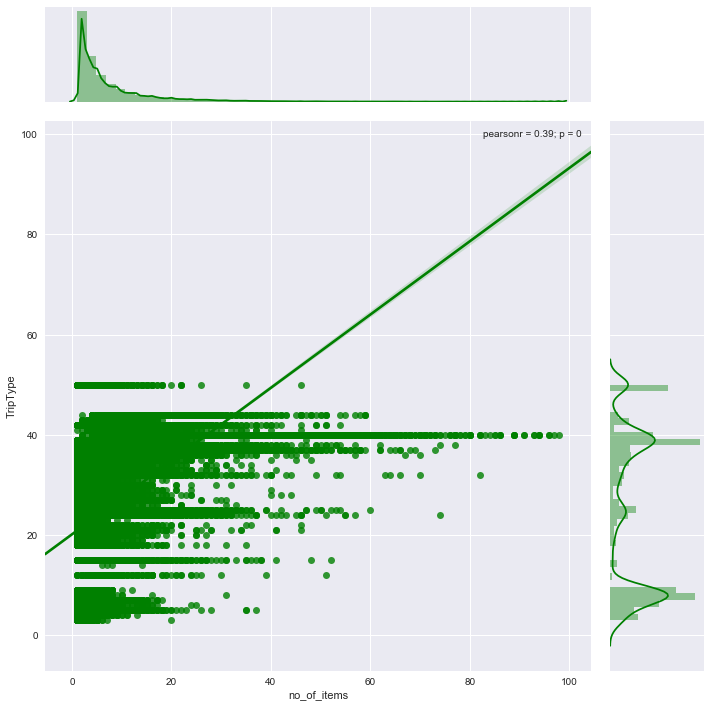

In [14]:
sns.jointplot(df_trip_corr.no_of_items, df_trip_corr.TripType.replace(to_replace=999,value=50),  
              kind="reg", size=10, color='g')
plt.savefig('no_item_trip_type_corr.png')
plt.show()

***
Add the next feature, i.e. the top 10% UPCs

In [16]:
#get the to 5% of UPC numbers
top_10pc_upc=upc_counts[:int(len(upc_counts)*0.05)]['str_upc']

In [17]:
top_10pc_upc

0              4011
1       60538862097
2        7874235186
3        7874235187
4              4046
5       68113107862
6       60538871457
7        3338320027
8              4087
9       60538871461
10       4900000044
11             4062
12             4065
13       4900003165
14       3338365020
15       7874235188
16       4900005010
17      60538896309
18      68113163351
19             4078
20      69922162117
21       7874211433
22             4093
23       4900000977
24      20966500000
25      60538819035
26       7874235201
27             4051
28       7225003706
29             3151
           ...     
4855     7756725434
4856     4114312870
4857     1910011838
4858    68113179201
4859     7007453360
4860     1600027517
4861     3400000481
4862    78616211000
4863     7874201855
4864     7874201849
4865     1117999847
4866    22813300000
4867    84105800520
4868     7874207177
4869     7352580563
4870     3000004090
4871     7046203596
4872     7524320439
4873     7874211461


In [18]:
df_walmart_1st_cleanse['str_upc']=df_walmart_1st_cleanse['Upc'].apply(str)
df_walmart_1st_cleanse['str_upc']=df_walmart_1st_cleanse.str_upc.map(lambda x : x[:-2])

C:\Anac\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anac\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
df_walmart_1st_cleanse.head(3)

TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   

  DepartmentDescription  FinelineNumber      str_upc  
0    FINANCIAL SERVICES          1000.0  68113152929  
1                 SHOES          8931.0  60538815980  
2         PERSONAL CARE          4504.0   7410811099

In [20]:
df_top10_upc=df_walmart_1st_cleanse[df_walmart_1st_cleanse.str_upc.isin(top_10pc_upc)][['VisitNumber','str_upc']]

In [21]:
df_top10_upc=pd.DataFrame(df_top10_upc.groupby(['VisitNumber','str_upc']).size()).reset_index()

In [22]:
df_top10_upc=pd.DataFrame.pivot_table(df_top10_upc,index='VisitNumber',columns='str_upc',fill_value=0)

In [23]:
df_top10_upc.shape

(69347, 4885)

In [24]:
df_top10_upc.columns=df_top10_upc.columns.droplevel(0)

In [25]:
df_visits=df_visits.join(df_top10_upc,how='left').fillna(0)

In [34]:
df_visits.iloc[0:2]

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                                     
5                                 0             0           0   
7                                 0             0           0   

             LARGE HOUSEHOLD GOODS  LAWN AND GARDEN  LIQUOR,WINE,BEER  \
VisitNumber                                                             
5                                0                0                 0   
7                                0                0                 0   

             MEAT - FRESH & FROZEN  MEDIA AND GAMING  MENS WEAR  MENSWEAR  \
VisitNumber                                                                 
5                                0                 0          0         0   
7                                0                 0          0         0   

             OFFICE SUPPLIES  OPTIC

In [35]:
df_visits.shape

(94247, 4956)

***
Now add the next feature
<ul>
<li>The top 30% of Fineline Number 
</ul>

In [26]:
flno_counts=pd.DataFrame(df_walmart_raw.groupby('FinelineNumber').size().sort_values(ascending=False))

In [27]:
top_30pc_flno=flno_counts.reset_index()['FinelineNumber'].iloc[0:int(.3*len(flno_counts))]

In [28]:
#df_top10_upc=df_walmart_1st_cleanse[df_walmart_1st_cleanse.str_upc.isin(top_10pc_upc)][['VisitNumber','str_upc']]
df_top_30pc_flno=df_walmart_1st_cleanse[df_walmart_1st_cleanse.FinelineNumber.isin(top_30pc_flno)][['VisitNumber','FinelineNumber']]

In [29]:
#df_top10_upc=pd.DataFrame(df_top10_upc.groupby(['VisitNumber','str_upc']).size()).reset_index()
df_top_30pc_flno=pd.DataFrame(df_top_30pc_flno.groupby(['VisitNumber','FinelineNumber']).size()).reset_index()


In [30]:
#df_top10_upc=pd.DataFrame.pivot_table(df_top10_upc,index='VisitNumber',columns='str_upc',fill_value=0)
df_top_30pc_flno=pd.DataFrame.pivot_table(df_top_30pc_flno,index='VisitNumber',columns='FinelineNumber',fill_value=0)

In [31]:
df_top_30pc_flno.shape

(87827, 1558)

In [32]:
df_top_30pc_flno.columns=df_top_30pc_flno.columns.droplevel(0)

In [33]:
df_visits=df_visits.join(df_top_30pc_flno,how='left').fillna(0)

In [93]:
df_visits.iloc[0:2]

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                                     
5                                 0             0           0   
7                                 0             0           0   

             LARGE HOUSEHOLD GOODS  LAWN AND GARDEN  LIQUOR,WINE,BEER  \
VisitNumber                                                             
5                                0                0                 0   
7                                0                0                 0   

             MEAT - FRESH & FROZEN  MEDIA AND GAMING  MENS WEAR  MENSWEAR  \
VisitNumber                                                                 
5                                0                 0          0         0   
7                                0                 0          0         0   

             OFFICE SUPPLIES  OPTIC

In [34]:
df_visits.shape

(94247, 6514)

***
Prepare the data to feed into the models. Move the TripType columns as the last column, this will be the Y. Change Weekday to a numerical value.

In [35]:
#store the visits and ther trip types
visits_triptype=df_visits['TripType']

In [36]:
#drop the TripType columns
df_visits= df_visits.drop(['TripType'],axis=1)

In [37]:
#update weekdays to numbers
df_visits['Weekday'] =df_visits['Weekday'].map({'Sunday':1,
'Monday':2,
'Tuesday':3,
'Wednesday':4,
'Thursday':5,
'Friday':6,
'Saturday':7})

In [38]:
#add the trip type to the end of the dataframe
df_visits['TripType']=visits_triptype.values

In [107]:
df_visits.iloc[0]

no_of_items                     1.0
Weekday                         6.0
1-HR PHOTO                      0.0
ACCESSORIES                     0.0
AUTOMOTIVE                      0.0
BAKERY                          0.0
BATH AND SHOWER                 0.0
BEAUTY                          0.0
BEDDING                         0.0
BOOKS AND MAGAZINES             0.0
BOYS WEAR                       0.0
BRAS & SHAPEWEAR                0.0
CAMERAS AND SUPPLIES            0.0
CANDY, TOBACCO, COOKIES         0.0
CELEBRATION                     0.0
COMM BREAD                      0.0
CONCEPT STORES                  0.0
COOK AND DINE                   0.0
DAIRY                           0.0
DSD GROCERY                     0.0
ELECTRONICS                     0.0
FABRICS AND CRAFTS              0.0
FINANCIAL SERVICES             -1.0
FROZEN FOODS                    0.0
FURNITURE                       0.0
GIRLS WEAR, 4-6X  AND 7-14      0.0
GROCERY DRY GOODS               0.0
HARDWARE                    

In [49]:
#store this as a csv file
#df_visits.to_csv('Formatted_Visits.csv')

In [50]:
df_visits.shape

(94247, 6514)

****

# Machine Learning  - Applying Models

Setup training and testing data

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
train_df, test_df = train_test_split(df_visits,test_size=0.2,random_state=1)

In [53]:
train_df.head(5)

no_of_items  Weekday  1-HR PHOTO  ACCESSORIES  AUTOMOTIVE  \
VisitNumber                                                              
152828                 1        2           0            0           0   
125876                 3        5           0            0           0   
31200                  1        3           0            0           0   
101761                 5        1           0            0           0   
22569                  7        2           0            0           0   

             BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  BOOKS AND MAGAZINES  \
VisitNumber                                                                  
152828            0                0       0        0                    0   
125876            0                0       0        0                    0   
31200             0                0       0        0                    0   
101761            0                0       0        0                    0   
22569             0                0       0        0                    0   

             BOYS WEAR  BRAS & SHAPEWEAR  CAMERAS AND SUPPLIES  \
VisitNumber                                                      
152828               0                 0                     0   
125876               0                 0                     0   
31200                0                 0                     0   
101761               2                 0                     0   
22569                2                 0                     0   

             CANDY, TOBACCO, COOKIES  CELEBRATION  COMM BREAD  CONCEPT STORES  \
VisitNumber                                                                     
152828                             0            0           0               0   
125876                             0            0           0               0   
31200                              0            0           0               0   
101761                             0            0           0               0   
22569                              0            0           0               0   

             COOK AND DINE  DAIRY  DSD GROCERY  ELECTRONICS  \
VisitNumber                                                   
152828                   0      0            0            1   
125876                   0      0            0            0   
31200                    0      0            1            0   
101761                   0      0            0            0   
22569                    1      0            2            0   

             FABRICS AND CRAFTS  FINANCIAL SERVICES  FROZEN FOODS  FURNITURE  \
VisitNumber                                                                    
152828                        0                   0             0          0   
125876                        0                   0             0          0   
31200                         0                   0             0          0   
101761                        0                   1             0          0   
22569                         0                   0             0          0   

             GIRLS WEAR, 4-6X  AND 7-14  GROCERY DRY GOODS  HARDWARE  \
VisitNumber                                                            
152828                                0                  0         0   
125876                                0                  0         0   
31200                                 0                  0         0   
101761                                0                  0         0   
22569                                 0                  0         0   

             HEALTH AND BEAUTY AIDS  HOME DECOR  HOME MANAGEMENT  \
VisitNumber                                                        
152828                            0           0                0   
125876                            0           0                0   
31200                             0           0                0   
101761                            0           0                0   


In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
X=train_df.iloc[:,:-1]#all the features
Y=train_df.iloc[:,-1:]#trip type to be predicted

In [43]:
X = X.as_matrix().astype(np.float)
Y = Y.as_matrix().astype(np.float)
Y=Y.ravel()

In [44]:
X.shape,Y.shape

((75397, 6513), (75397,))

In [45]:
Xtest=test_df.iloc[:,:-1]
Ytest=test_df.iloc[:,-1:]

In [46]:
Xtest.shape,Ytest.shape

((18850, 6513), (18850, 1))

First model to be applied ** Logistic Regression **

In [140]:
logreg=LogisticRegression(solver='sag',max_iter=100)

In [141]:
%%time
logreg.fit(X,Y)

C:\Anac\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 4h 35min 50s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [142]:
Ypredict=logreg.predict(Xtest)

In [143]:
'''
Calculate the accuracy of the model prediction
Accuracy calculated as % of accurate prediction of the test set. Given by,
(actual Trip Type - predicted Trip Type) - total predictions
'''
#sag;C=default; accuracy = 0.61243718592964824
#sag;C=1e5; accuracy = 0.61254187604690113
#sag;C=1e7; accuracy = 0.61259422110552764
#liblinear;accuracy = 0.60945351758793975
#newton-cg;accuray = 0.60924413735343386
#lbfgs;accuracy = 0.60940117252931325

((np.array(pd.Series(Ytest['TripType']).values)-Ypredict)==0).sum() / len(Ypredict)



0.66323607427055697

In [144]:
logreg.score(Xtest,Ytest)

0.66323607427055697

The logistic regression model takes a considerable time, approx. 4.5 Hours. It produces an ** accuracy of 66.32% **

***
Next model is ** SGD Classifier **

In [145]:
from sklearn.linear_model import SGDClassifier

In [146]:
sgdclf=SGDClassifier()

In [147]:
%%time
sgdclf.fit(X,Y)

Wall time: 2min 32s


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [148]:
sgdclf.score(Xtest,Ytest)

0.6124668435013263

SGD Classifier is much quicker to train, it just took 2 minutes and 32 seconds. The accuracy of this model is ** 61% **
***
Next model : ** SVC **

In [149]:
from sklearn.svm import SVC

In [151]:
SVCclf=SVC()

In [152]:
%%time
SVCclf.fit(X,Y)

Wall time: 11h 36min 41s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [153]:
SVCclf.score(Xtest,Ytest)

0.4394164456233422

SVC takes the most time, by far. It takes ** 11.5 Hours ** to train. The ** accuracy of the model is very low **, 44%.
***
Next model : ** Linear SVC **

In [230]:
from sklearn.svm import LinearSVC

In [232]:
LSVCclf = LinearSVC()

In [233]:
%%time
LSVCclf.fit(X,Y)

Wall time: 2min 18s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [234]:
LSVCclf.score(Xtest,Ytest)

0.62127320954907161

Linear SVC takes less time (2 minutes) and the ** accuracy (62%) ** is almost the same as logistic regression. 
***
Next model : ** Gaussian Naive Bayes **

In [154]:
from sklearn.naive_bayes import GaussianNB

In [155]:
gnbclf=GaussianNB()

In [157]:
%%time
gnbclf.fit(X,Y)

Wall time: 16.4 s


GaussianNB(priors=None)

In [158]:
gnbclf.score(Xtest,Ytest)

0.20694960212201591

The Gaussian Naive Bayes is the ** quickest of all **, taking only 16.4 seconds, the ** accuracy is also the least **, 20.7%.
***
Next model: ** Decision Tree **

In [159]:
from sklearn import tree

In [163]:
dtreeclf = tree.DecisionTreeClassifier()

In [164]:
%%time
dtreeclf.fit(X,Y)

Wall time: 1min 4s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [166]:
dtreeclf.score(Xtest,Ytest)

0.61755968169761277

The Decision Tree is fairly quick to train, takes 1 minute. The ** accuracy, 61.7% ** is close to the SGD classifier.
***
Next model : ** Random Forest Classifier **

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

C:\Anac\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anac\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [48]:
rf1clf = RandomForestClassifier(n_estimators=50,n_jobs=2)

In [68]:
%%time
rf1clf.fit(X,Y)

Wall time: 1min 36s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [69]:
rf1clf.score(Xtest,Ytest)

0.67750663129973476

The Random Forest classifier produces the ** most accurate results on the test data set, 68.12% **. It takes around 4 minutes to train the model.
***
Tune the model parameters to acheive better accuracy. The most important parameters of this model are `n_estimators` and `max_features`

In [61]:
parameters = {"n_estimators": [20,40,50,60],"max_features":['auto','sqrt','log2']}
rfclf = RandomForestClassifier(n_jobs=-1)

In [64]:
%%time
fitmodel = GridSearchCV(rfclf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(X,Y)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

***best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
***best params: {'max_features': 'auto', 'n_estimators': 60}
***best score: 0.678408955263472
***grid scores: [mean: 0.65973, std: 0.00230, params: {'max_features': 'auto', 'n_estimators': 20}, mean: 0.67462, std: 0.00242, params: {'max_features': 'auto', 'n_estimators': 40}, mean: 0.67828, std: 0.00202, params: {'max_features': 'auto', 'n_estimators': 50}, mean: 0.67841, std: 0.00343, params: {'max_features': 'auto', 'n_estimators': 60}, mean: 0.65975, std: 0.00078, params: {'max_features': 'sqrt', 'n_estimators': 20}, mean: 0.67456, std: 0.00192, params: {'max_features': 'sqrt', 'n_estima

In [82]:
rf2clf = fitmodel.best_estimator_

In [84]:
%%time
rf2clf.fit(X,Y)


Wall time: 1min 21s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [85]:
rf2clf.score(Xtest,Ytest)

0.67856763925729446

In [139]:
parameters = {"n_estimators": [50,60,70],"max_depth":[1800,2000,2200,2500]}
rfclf = RandomForestClassifier(n_jobs=-1)

In [140]:
%%time
fitmodel = GridSearchCV(rfclf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(X,Y)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

***best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2200, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
***best params: {'max_depth': 2200, 'n_estimators': 70}
***best score: 0.6809024231733358
***grid scores: [mean: 0.67618, std: 0.00313, params: {'max_depth': 1800, 'n_estimators': 50}, mean: 0.67936, std: 0.00478, params: {'max_depth': 1800, 'n_estimators': 60}, mean: 0.67922, std: 0.00328, params: {'max_depth': 1800, 'n_estimators': 70}, mean: 0.67903, std: 0.00303, params: {'max_depth': 2000, 'n_estimators': 50}, mean: 0.67878, std: 0.00233, params: {'max_depth': 2000, 'n_estimators': 60}, mean: 0.68019, std: 0.00359, params: {'max_depth': 2000, 'n_estimators': 70}, mean: 0.67767, std: 0.

In [141]:
rf3clf = fitmodel.best_estimator_

In [142]:
%%time
rf3clf.fit(X,Y)

Wall time: 1min 32s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2200, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [144]:
rf3clf.score(Xtest,Ytest)

0.68185676392572947

In [145]:
feat_importance = rf3clf.feature_importances_

In [159]:
#sort the feature by importance, from the most important ones to least important ones
feat_imp_sort_ix=feat_importance.argsort()[::-1]

In [170]:
#the most important features are
train_df.columns[feat_imp_sort_ix[0:10]]

Index(['no_of_items', 'DSD GROCERY', 'Weekday', 'PHARMACY OTC',
       'PERSONAL CARE', 'GROCERY DRY GOODS', 'MENS WEAR', 'DAIRY', 'PRODUCE',
       'SERVICE DELI'],
      dtype='object')

In [240]:
from sklearn.metrics import confusion_matrix
import itertools

In [255]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, axes = plt.subplots(figsize=(22,22))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

Normalized confusion matrix
[[  9.93489583e-01   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.40845070e-02   5.63380282e-01   3.38028169e-01 ...,   0.00000000e+00
    0.00000000e+00   1.40845070e-02]
 [  1.48148148e-03   5.92592593e-03   7.43703704e-01 ...,   0.00000000e+00
    0.00000000e+00   1.48148148e-03]
 ..., 
 [  0.00000000e+00   0.00000000e+00   2.65957447e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   3.84615385e-03 ...,   0.00000000e+00
    3.84615385e-03   0.00000000e+00]
 [  4.26829268e-03   6.09756098e-04   6.70731707e-03 ...,   0.00000000e+00
    0.00000000e+00   8.65853659e-01]]


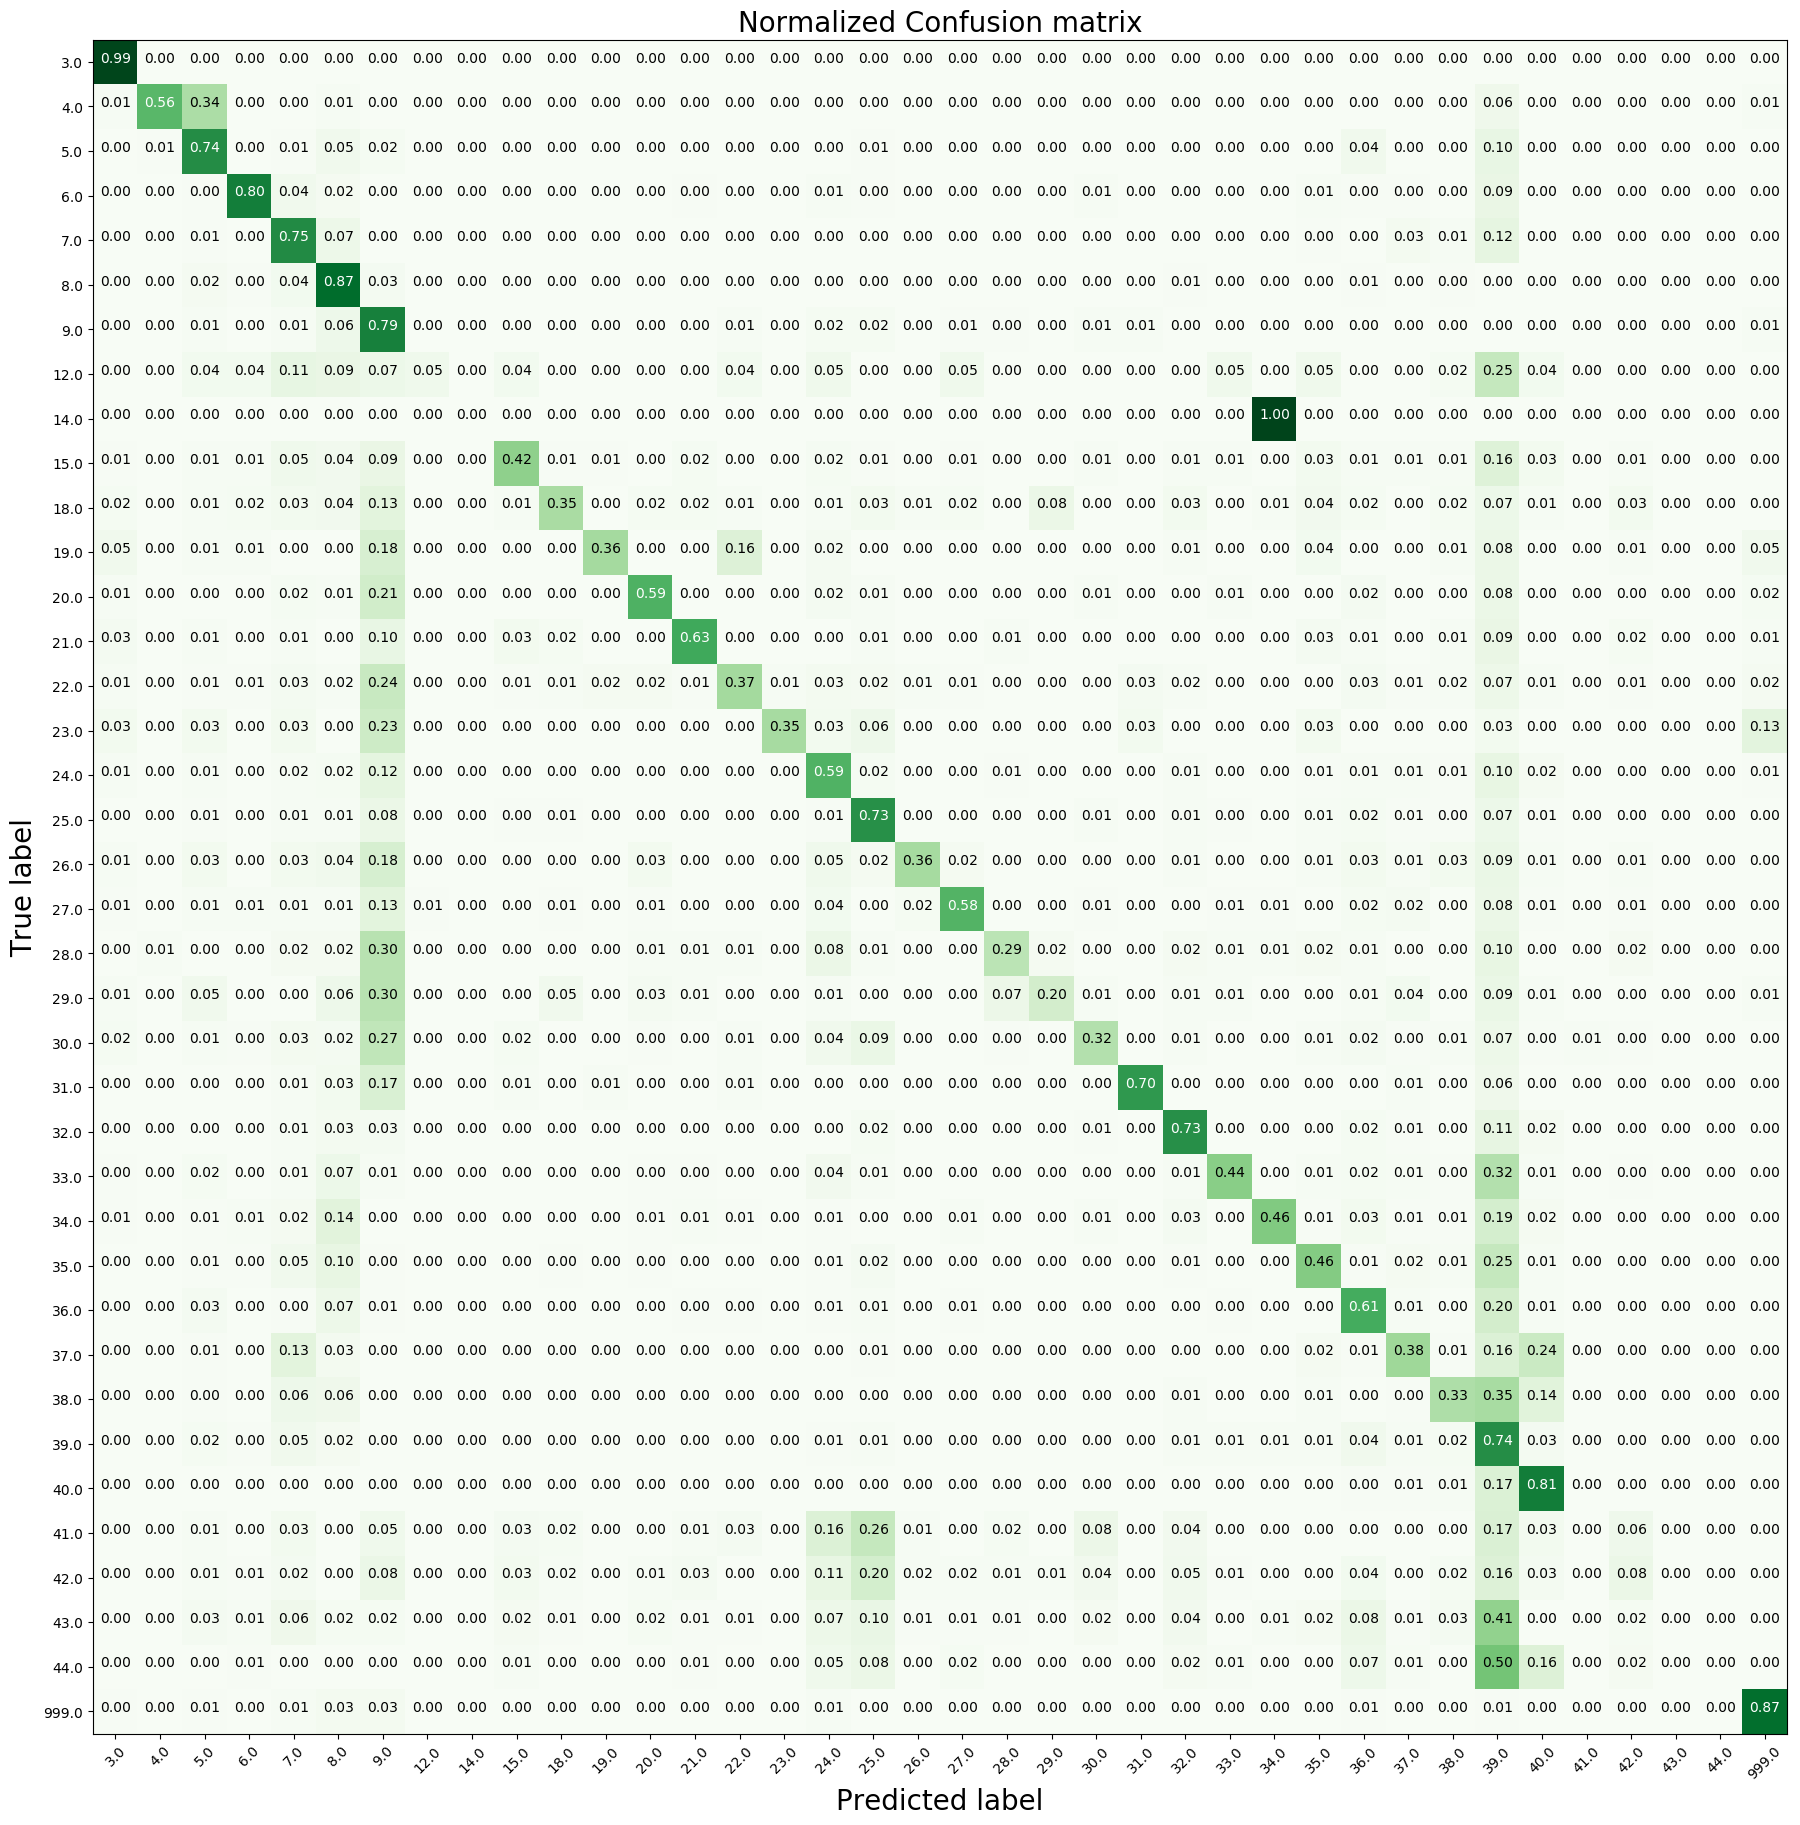

In [257]:
Ypred=rf3clf.predict(Xtest)
cnf_matrix = confusion_matrix(Ytest, Ypred)
plot_confusion_matrix(cnf_matrix, classes=rf3clf.classes_, normalize=True,
                      title='Normalized Confusion matrix')
#plt.savefig('ConfusionMatrix.png')
plt.show()